# Analysis of Newcastle University Special Collectives Descriptive Metadata

* **Source:** [Newcastle University Special Collections & Archives](https://specialcollections.ncl.ac.uk)
* **Contents:** EAD XML records (descriptions from the *Title*, *Biographical / Historical*, *Scope and Contents*, and *Processing Information* metadata fields) and transcriptions from the Gertrude Bell Archive
* **Date extracted:** May 2025

In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger_eng')
from nltk.tag import pos_tag
nltk.download('tagsets')  # part of speech tags

from pathlib import Path

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


Create a directory to save analysis outputs to.

In [2]:
extracted_dir = "data/analysis/"
Path(extracted_dir).mkdir(parents=True, exist_ok=True)

Load the descriptive metadata extracted from NUSC's catalog as a DataFrame.

In [3]:
f = "data/extracted/nusc_archival_descs_consolidated.csv" #"data/extracted/newcastle_archival_metadata_sample.csv"  #"data/extracted/nusc_archival_descs_for_clf.csv"

In [5]:
df = pd.read_csv(f, index_col=0)
assert df.shape[0] == (df.drop_duplicates()).shape[0], "No duplicates found (each description is unique)."
print(df.shape)
df.head(2)

(99312, 5)


,description_id,eadid,rowid,field,doc
0,0,17th C. Coll,17th C. Coll,bioghist,Formed in 1963 after an amalgamation of instit...
1,1,17th C. Coll,17th C. Coll,scopecontent,The 17th Century Collection is a small but exp...


In [85]:
df.field.unique()

array(['bioghist', 'scopecontent', 'unittitle', 'processinfo',
       'extent-and-medium', 'title', 'description'], dtype=object)

Comment/uncomment the selection of descriptions to analyze:

In [86]:
# all = list(df["doc"])
# all[0]

pi = list(df.loc[df["field"] == "processinfo"].doc)
pi[0]

sc = list(df.loc[df["field"] == "scopecontent"].doc)
sc[0]

bh = list(df.loc[df["field"] == "bioghist"].doc)
bh[0]

ut = list(df.loc[df["field"] == "unittitle"].doc)
ut[0]

# Gertrude Bell Archive metadata only
# ------------------------------------
# em = list(df.loc[df["field"] == "extent-and-medium"].doc)
# em[0]

# t = list(df.loc[df["field"] == "title"].doc)
# t[0]

# d = list(df.loc[df["field"] == "description"].doc)
# d[0]

'17th Century Collection'

Update the `descs` variable below with whichever descriptive metadata field(s) you wish to analyze.

In [87]:
descs = ut + bh + sc + pi # EAD only   #all # EAD and Bell      #ut + t # titles only
print(len(descs))

75165


## Exploratory Analysis

In [8]:
punctuation = list(string.punctuation)
print(punctuation)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [9]:
sentences = [sent_tokenize(d) for d in descs]
print(sentences[1])
print(len(sentences[1]))

['18th Century Collection']
1


In [10]:
assert len(sentences) == len(descs)

In [11]:
tokens_with_punc = [word_tokenize(d) for d in descs]
# Remove punctuation
tokens = []
for token_list in tokens_with_punc:
    new_token_list = [t for t in token_list if t not in punctuation]
    tokens.append(new_token_list)
print(tokens[1])
print(len(tokens[1]))

['18th', 'Century', 'Collection']
3


In [12]:
assert len(tokens) == len(descs)

In [13]:
tokens_flat = [t for token_list in tokens for t in token_list]  # maintaining original capitalization

In [14]:
tokens_flat_lower = [t.lower() for token_list in tokens for t in token_list]  # lowercasing all tokens
print(tokens_flat_lower[:10])

['17th', 'century', 'collection', '18th', 'century', 'collection', '19th', 'century', 'collection', '20th']


### Counts by Description

In [15]:
sentence_counts = [len(sentence_list) for sentence_list in sentences]  # count of sentences per description
print("Mean:", np.mean(sentence_counts))
print("Median:", np.median(sentence_counts))
print("Standard Deviation:", np.std(sentence_counts))
print("Minimum:", np.min(sentence_counts))
print("Maximum:", np.max(sentence_counts))

Mean: 1.657579990687155
Median: 1.0
Standard Deviation: 2.3960121023378416
Minimum: 1
Maximum: 91


In [16]:
token_counts = [len(token_list) for token_list in tokens]  # count of tokens per description
print("Mean:", np.mean(token_counts))
print("Median:", np.median(token_counts))
print("Standard Deviation:", np.std(token_counts))
print("Minimum:", np.min(token_counts))
print("Maximum:", np.max(token_counts))

Mean: 25.48220581387614
Median: 9.0
Standard Deviation: 63.48136719735124
Minimum: 0
Maximum: 2296


In [17]:
df_by_desc = pd.DataFrame({
    "sentences_per_description":[np.mean(sentence_counts), np.median(sentence_counts), np.std(sentence_counts), np.min(sentence_counts), np.max(sentence_counts)],
    "tokens_per_description":[np.mean(token_counts), np.median(token_counts), np.std(token_counts), np.min(token_counts), np.max(token_counts)]
}, index=["mean", "median", "standard_deviation", "minimum", "maximum"])
df_by_desc

,sentences_per_description,tokens_per_description
mean,1.657580,25.482206
median,1.000000,9.000000
standard_deviation,2.396012,63.481367
minimum,1.000000,0.000000
maximum,91.000000,2296.000000


### Counts by Sentence

In [18]:
tokens_by_sentence = [word_tokenize(s) for sentence_list in sentences for s in sentence_list]
print(tokens_by_sentence[0])

['17th', 'Century', 'Collection']


In [19]:
token_counts_by_sentence = [len(token_list) for token_list in tokens_by_sentence]
print("Mean:", np.mean(token_counts_by_sentence))
print("Median:", np.median(token_counts_by_sentence))
print("Standard Deviation:", np.std(token_counts_by_sentence))
print("Minimum:", np.min(token_counts_by_sentence))
print("Maximum:", np.max(token_counts_by_sentence))

Mean: 17.538429433671503
Median: 13.0
Standard Deviation: 16.256025445870012
Minimum: 1
Maximum: 1676


In [20]:
df_by_sent = pd.DataFrame({
    "tokens_per_sentence":[np.mean(token_counts_by_sentence), np.median(token_counts_by_sentence), np.std(token_counts_by_sentence), np.min(token_counts_by_sentence), np.max(token_counts_by_sentence)]
}, index=["mean", "median", "standard_deviation", "minimum", "maximum"])
df_by_sent

,tokens_per_sentence
mean,17.538429
median,13.000000
standard_deviation,16.256025
minimum,1.000000
maximum,1676.000000


In [45]:
df_stats = pd.concat([df_by_desc, df_by_sent], axis=1)
df_stats

,sentences_per_description,tokens_per_description,tokens_per_sentence
mean,1.657580,25.482206,17.538429
median,1.000000,9.000000,13.000000
standard_deviation,2.396012,63.481367,16.256025
minimum,1.000000,0.000000,1.000000
maximum,91.000000,2296.000000,1676.000000


### Counts Overall

In [22]:
total_sentences = sum(sentence_counts)
total_tokens = len(tokens_flat_lower)
print("Total sentences: ", total_sentences)
print("Total tokens: ", total_tokens)

# All EAD + Bell:
# Total sentences:  151580
# Total tokens:  2446557

Total sentences:  124592
Total tokens:  1915370


In [23]:
print("Unique tokens: ", len(set(tokens_flat_lower)))

# All EAD + Bell:
# Unique tokens:  45614

Unique tokens:  42531


In [24]:
df_total = pd.DataFrame({"sentences_per_description":total_sentences, "tokens_per_description":total_tokens, "tokens_per_sentence":total_tokens}, index=["total"])
df_total

,sentences_per_description,tokens_per_description,tokens_per_sentence
total,124592,1915370,1915370


In [46]:
df_stats = pd.concat([df_stats, df_total], axis=0)
df_stats

,sentences_per_description,tokens_per_description,tokens_per_sentence
mean,1.657580,2.548221e+01,1.753843e+01
median,1.000000,9.000000e+00,1.300000e+01
standard_deviation,2.396012,6.348137e+01,1.625603e+01
minimum,1.000000,0.000000e+00,1.000000e+00
maximum,91.000000,2.296000e+03,1.676000e+03
total,124592.000000,1.915370e+06,1.915370e+06


Save the table of descriptive statistics as a CSV file.

In [26]:
df_stats.to_csv(extracted_dir + "nusc_ead_descs_stats.csv")

### Root Forms: Lemmatize & Stem

In [27]:
stop_words = set(stopwords.words('english') + list(string.punctuation) + list(string.digits))

In [28]:
print(stop_words)

{'aren', 've', 'this', 'ain', 'is', 'where', 're', ')', 'out', '6', 'have', "aren't", 'why', 'into', 'do', '`', 'does', 'before', 'them', 'under', 'and', 'only', 'as', 'very', '?', "wouldn't", 'mightn', 'until', 'above', 'are', '[', "they'd", 'yourself', "she's", "they're", 'so', 'having', 'theirs', 'once', '9', "we're", 'wouldn', 'any', 'further', 'who', 'they', "i've", 'shan', 'be', 'each', "should've", '7', 'o', '4', 'its', 'yourselves', 'too', ';', 'didn', '5', 'their', 'haven', '(', "i'm", "'", ',', '/', 'been', 'i', 'through', "they'll", '3', 'nor', 'just', '1', 'had', 'couldn', "that'll", "we'd", '}', 'hasn', '{', '~', "he's", 'his', '\\', 'between', "it's", 'same', 'most', 'such', 'an', 'of', 'few', '=', 'being', 'not', 'wasn', "you'll", 's', "you're", 'from', '<', 'hers', 'y', "don't", 't', '&', "didn't", 'for', '.', '0', 'it', 'was', '$', 'won', '!', 'you', 'again', "couldn't", 'while', 'by', 'what', 'will', '+', '-', 'myself', "she'd", "i'll", 'on', 'when', 'during', '8', "w

In [29]:
wnl = nltk.WordNetLemmatizer()
lemmas = [wnl.lemmatize(t) for t in tokens_flat_lower if t.isalpha()]
filtered_lemmas = [l for l in lemmas if l not in stop_words]
print("Total lemmas: ", len(lemmas))
print("Total filtered lemmas: ", len(filtered_lemmas))
print("Unique lemmas: ", len(set(lemmas)))
print("Unique filtered lemmas: ", len(set(filtered_lemmas)))

Total lemmas:  1788667
Total filtered lemmas:  1134186
Unique lemmas:  26530
Unique filtered lemmas:  26395


In [30]:
ps = PorterStemmer()
stems = [ps.stem(t) for t in tokens_flat_lower if t.isalpha()]
filtered_stems = [s for s in stems if s not in stop_words]
print("Total stems: ", len(stems))
print("Total filtered stems: ", len(filtered_stems))
print("Unique stems: ", len(set(stems)))
print("Unique filtered stems: ", len(set(filtered_stems)))

Total stems:  1788667
Total filtered stems:  1151434
Unique stems:  22332
Unique filtered stems:  22214


In [31]:
print(lemmas[100:110])
print(stems[100:110])

['launch', 'of', 'air', 'business', 'planning', 'file', 'event', 'programme', 'file', 'scotland']
['launch', 'of', 'air', 'busi', 'plan', 'file', 'event', 'programm', 'file', 'scotland']


### Grammatically and Lexically Gendered Word Counts

In [32]:
word_list = [
    "woman", "women", "girl", "girls", "man", "men", "boy", "boys", 
    "she", "he", "her", "him", "hers", "his",
    "mother", "father", "daughter", "son", "sister", "brother",
    "aunt", "uncle", "niece", "nephew", "grandmother", "grandfather",
    "granddaughter", "grandson", "wife", "husband"
    ]

In [33]:
filtered_tokens = [t for t in tokens_flat_lower if t not in stop_words]
filtered_tokens = [t for t in filtered_tokens if t.isalpha()]
filtered_tokens_fdist = FreqDist(filtered_tokens)
lower_tokens_counts = []
for w in word_list:
    lower_tokens_counts += [filtered_tokens_fdist[w]]
lower_tokens_df = pd.DataFrame({"word":word_list, "count":lower_tokens_counts})
lower_tokens_df = lower_tokens_df.sort_values(by="count")
# lower_tokens_df
lower_tokens_df.to_csv(extracted_dir+"nusc_ead_gendered_lower_token_counts_ead.csv", index=False)

In [34]:
capitalized_word_list = [
    "Mrs", "Ms", "Miss", "Mr", "Messrs", "Lady", "Lord",
    "gentleman", "gentlemen", "ladies", "lady", "Duke", "Duchess",
    "King", "Queen", "Prince", "Princess", "Countess", "Count",
    "Baroness", "Baron", "Viscountess", "Viscount", "Dame", "Sir"
    ]

In [35]:
cap_tokens_filtered = [t for t in tokens_flat if t.isalpha()]
cap_tokens_filtered = [t for t in cap_tokens_filtered if t not in stop_words]
cap_tokens_fdist = FreqDist(cap_tokens_filtered)
cap_tokens_counts = []
for w in capitalized_word_list:
    cap_tokens_counts += [cap_tokens_fdist[w]]
cap_tokens_df = pd.DataFrame({"word":capitalized_word_list, "count":cap_tokens_counts})
cap_tokens_df = cap_tokens_df.sort_values(by="count")
# cap_tokens_df
cap_tokens_df.to_csv(extracted_dir+"nusc_ead_gendered_capitalized_token_counts.csv", index=False)

### Frequency Distributions

In [36]:
print("Total alphabetic tokens:", len(filtered_tokens))

Total alphabetic tokens: 1113240


<Axes: title={'center': 'Top 30 most common alphabetic tokens'}, xlabel='Samples', ylabel='Counts'>

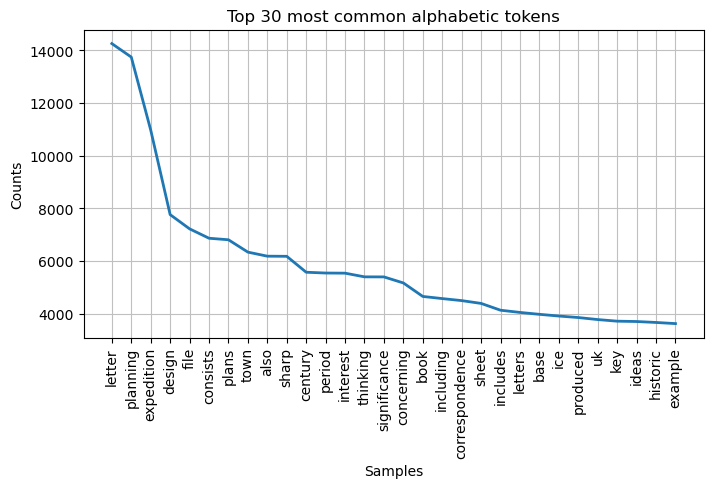

In [37]:
fdist_tokens = FreqDist(filtered_tokens)
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
n = 30
fdist_tokens.plot(n, title=f"Top {n} most common alphabetic tokens")

<Axes: title={'center': 'Top 30 most common lemmas'}, xlabel='Samples', ylabel='Counts'>

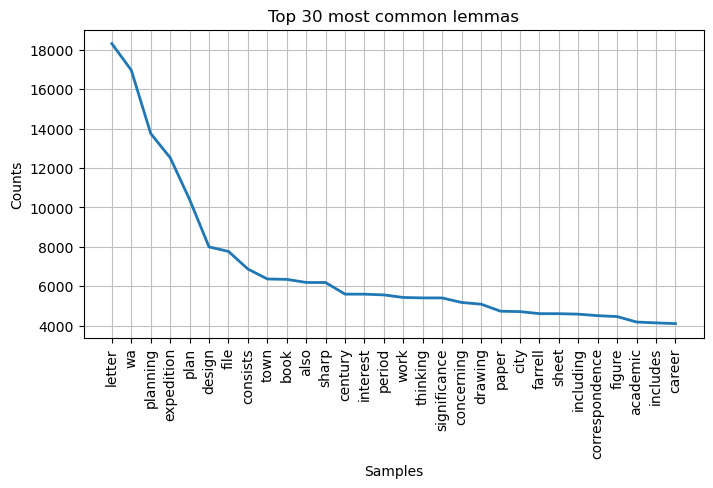

In [38]:
fdist_lemmas = FreqDist(filtered_lemmas)
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
n = 30 #10
fdist_lemmas.plot(n, title=f"Top {n} most common lemmas")

<Axes: title={'center': 'Top 30 most common stems'}, xlabel='Samples', ylabel='Counts'>

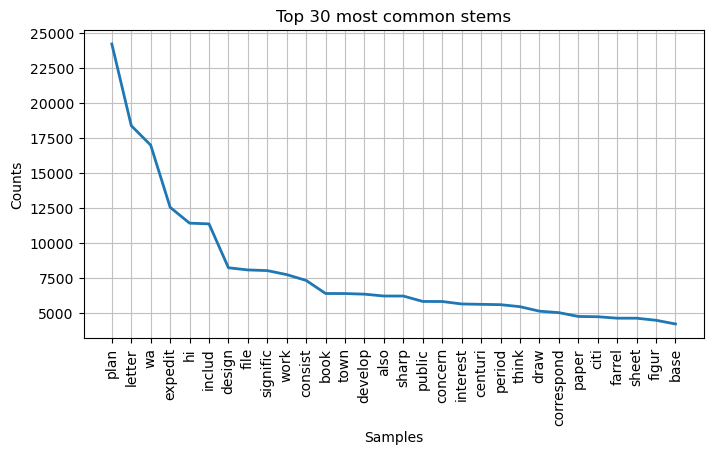

In [39]:
fdist_stems = FreqDist(filtered_stems)
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
n = 30 #10
fdist_stems.plot(n, title=f"Top {n} most common stems")

## Part of Speech Tagging

Use NLTK's default part-of-speech tagger to analyze the adjectives and adverbs of the descriptive metadata.

Select the DataFrame rows with descriptive metadata in EAD only.

In [48]:
df_pi = df.loc[df["field"] == "processinfo"]
df_sc = df.loc[df["field"] == "scopecontent"]
df_bh = df.loc[df["field"] == "bioghist"]
df_ut = df.loc[df["field"] == "unittitle"]
df_ead = pd.concat([df_pi, df_sc, df_bh, df_ut], axis=0)
df_ead.head()

,description_id,eadid,rowid,field,doc
21,21,AN,AN,processinfo,This description created by Ruth Sheret 04 Aug...
24,24,AN,AN-00001,processinfo,This description created by Ruth Sheret 04 Aug...
27,27,AN,AN-00002,processinfo,This description created by Ruth Sheret 04 Aug...
30,30,AN,AN-00003,processinfo,This description created by Ruth Sheret 04 Aug...
33,33,AN,AN-00004,processinfo,This description created by Ruth Sheret 04 Aug...


In [49]:
df_ead = df_ead.sort_values(by="description_id")
df_ead = df_ead.reset_index(drop=True)
df_ead.head()

,description_id,eadid,rowid,field,doc
0,0,17th C. Coll,17th C. Coll,bioghist,Formed in 1963 after an amalgamation of instit...
1,1,17th C. Coll,17th C. Coll,scopecontent,The 17th Century Collection is a small but exp...
2,2,17th C. Coll,17th C. Coll,unittitle,17th Century Collection
3,3,18th C. Coll,18th C. Coll,bioghist,Formed in 1963 after an amalgamation of instit...
4,4,18th C. Coll,18th C. Coll,scopecontent,The 18th Century Collection contains approxima...


In [50]:
df_ead.tail()

,description_id,eadid,rowid,field,doc
75160,99307,Wallis,Wallis,scopecontent,The Wallis Collection contains books on mathem...
75161,99308,Wallis,Wallis,unittitle,Wallis (Peter) Collection
75162,99309,Walmsley,Walmsley,bioghist,"A specialist in Caribbean art and literature, ..."
75163,99310,Walmsley,Walmsley,scopecontent,The Walmsley (Anne) Collection is named for th...
75164,99311,Walmsley,Walmsley,unittitle,Walmsley (Anne) Collection


In [51]:
ead_docs = list(df_ead["doc"])
ead_tokenized = [word_tokenize(doc) for doc in ead_docs]

In [52]:
pos_tagged = [nltk.pos_tag(token_list) for token_list in ead_tokenized]
pos_tagged[0]

[('Formed', 'VBN'),
 ('in', 'IN'),
 ('1963', 'CD'),
 ('after', 'IN'),
 ('an', 'DT'),
 ('amalgamation', 'NN'),
 ('of', 'IN'),
 ('institutions', 'NNS'),
 ('dating', 'VBG'),
 ('back', 'RB'),
 ('to', 'TO'),
 ('1834', 'CD'),
 (',', ','),
 ('Newcastle', 'NNP'),
 ('University', 'NNP'),
 ('is', 'VBZ'),
 ('based', 'VBN'),
 ('in', 'IN'),
 ('Newcastle', 'NNP'),
 ('upon', 'IN'),
 ('Tyne', 'NNP'),
 (',', ','),
 ('with', 'IN'),
 ('overseas', 'JJ'),
 ('campuses', 'NNS'),
 ('in', 'IN'),
 ('Malaysia', 'NNP'),
 ('and', 'CC'),
 ('Singapore', 'NNP'),
 ('.', '.'),
 ('It', 'PRP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('member', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('Russell', 'NNP'),
 ('Group', 'NNP'),
 ('of', 'IN'),
 ('Universities', 'NNP'),
 ('.', '.')]

In [53]:
df_ead.insert(2, "pos_tagged", pos_tagged)
df_ead.head()

,description_id,eadid,pos_tagged,rowid,field,doc
0,0,17th C. Coll,"[(Formed, VBN), (in, IN), (1963, CD), (after, ...",17th C. Coll,bioghist,Formed in 1963 after an amalgamation of instit...
1,1,17th C. Coll,"[(The, DT), (17th, JJ), (Century, NNP), (Colle...",17th C. Coll,scopecontent,The 17th Century Collection is a small but exp...
2,2,17th C. Coll,"[(17th, JJ), (Century, NNP), (Collection, NNP)]",17th C. Coll,unittitle,17th Century Collection
3,3,18th C. Coll,"[(Formed, VBN), (in, IN), (1963, CD), (after, ...",18th C. Coll,bioghist,Formed in 1963 after an amalgamation of instit...
4,4,18th C. Coll,"[(The, DT), (18th, JJ), (Century, NNP), (Colle...",18th C. Coll,scopecontent,The 18th Century Collection contains approxima...


In [54]:
df_pos = df_ead.drop(columns=["doc"])
df_pos = df_pos.explode("pos_tagged")
df_pos.head()

,description_id,eadid,pos_tagged,rowid,field
0,0,17th C. Coll,"(Formed, VBN)",17th C. Coll,bioghist
0,0,17th C. Coll,"(in, IN)",17th C. Coll,bioghist
0,0,17th C. Coll,"(1963, CD)",17th C. Coll,bioghist
0,0,17th C. Coll,"(after, IN)",17th C. Coll,bioghist
0,0,17th C. Coll,"(an, DT)",17th C. Coll,bioghist


In [55]:
df_pos[["pos_tagged", "pos"]] = df_pos["pos_tagged"].astype("string").str.split(", ", expand=True)
df_pos.head()

,description_id,eadid,pos_tagged,rowid,field,pos
0,0,17th C. Coll,('Formed',17th C. Coll,bioghist,'VBN')
0,0,17th C. Coll,('in',17th C. Coll,bioghist,'IN')
0,0,17th C. Coll,('1963',17th C. Coll,bioghist,'CD')
0,0,17th C. Coll,('after',17th C. Coll,bioghist,'IN')
0,0,17th C. Coll,('an',17th C. Coll,bioghist,'DT')


In [56]:
new_token_col = df_pos.pos_tagged.apply(lambda x: x.strip("('"))
new_pos_col = df_pos.pos.apply(lambda x: x.strip("')"))

In [57]:
df_pos = df_pos.drop(columns=["pos_tagged", "pos"])
df_pos.insert(2, "token", new_token_col)
df_pos.insert(2, "pos", new_pos_col)
df_pos.head()

,description_id,eadid,pos,token,rowid,field
0,0,17th C. Coll,VBN,Formed,17th C. Coll,bioghist
0,0,17th C. Coll,IN,in,17th C. Coll,bioghist
0,0,17th C. Coll,CD,1963,17th C. Coll,bioghist
0,0,17th C. Coll,IN,after,17th C. Coll,bioghist
0,0,17th C. Coll,DT,an,17th C. Coll,bioghist


In [58]:
# df_pos.to_csv(extracted_dir + "nusc_ead_descs_pos_tags.csv", index=False)
df_pos = pd.read_csv(extracted_dir + "nusc_ead_descs_pos_tags.csv")
df_pos.head()

,description_id,eadid,pos,token,field,rowid
0,0,17th C. Coll,VBN,Formed,bioghist,17th C. Coll
1,0,17th C. Coll,IN,in,bioghist,17th C. Coll
2,0,17th C. Coll,CD,1963,bioghist,17th C. Coll
3,0,17th C. Coll,IN,after,bioghist,17th C. Coll
4,0,17th C. Coll,DT,an,bioghist,17th C. Coll


In [59]:
df_pos.shape  # (2185143, 6)

(2185143, 6)

Replace `nan` values in the part-of-speech tag column, `pos`, with an empty string, so the entire column only contains string values.

In [60]:
df_pos["pos"] = df_pos["pos"].fillna('')
print(df_pos["pos"].unique())

['VBN' 'IN' 'CD' 'DT' 'NN' 'NNS' 'VBG' 'RB' 'TO' ',' 'NNP' 'VBZ' 'JJ' 'CC'
 '.' 'PRP' 'VBP' ':' 'VBD' '(' '' 'WDT' 'PRP$' 'JJR' 'POS' 'EX' 'WP' 'SYM'
 'NNPS' 'MD' 'VB' 'FW' 'WRB' '"\'\'"' 'RP' '$' '``' 'RBR' 'JJS' 'WP$'
 'RBS' 'PDT' 'UH' '#']


You can see what each of these tags indicates [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).  We're particularly interested in adjectives and adverbs, which are represented with the following tags:
* `JJ` - adjective
* `JJR` - comparative adjective
* `JJS` - superlative adjective
* `RB` - adverb
* `RBR` - comparative adverb
* `RBS` - superlative adverb

In [61]:
df_jj = df_pos.loc[df_pos["pos"] == "JJ"]
df_jjr = df_pos.loc[df_pos["pos"] == "JJR"]
df_jjs = df_pos.loc[df_pos["pos"] == "JJS"]
print(df_jj.shape[0], df_jjr.shape[0], df_jjs.shape[0])

128075 557 3044


In [62]:
df_adj = pd.concat([df_jj, df_jjr, df_jjs], axis=0)
print("Total adjectives:", df_adj.shape[0])
df_adj.head()

Total adjectives: 131676


,description_id,eadid,pos,token,field,rowid
23,0,17th C. Coll,JJ,overseas,bioghist,17th C. Coll
42,1,17th C. Coll,JJ,17th,scopecontent,17th C. Coll
47,1,17th C. Coll,JJ,small,scopecontent,17th C. Coll
54,1,17th C. Coll,JJ,1600-1699,scopecontent,17th C. Coll
62,1,17th C. Coll,JJ,good,scopecontent,17th C. Coll


Create a table of all the tokens tagged as adjectives (i.e., `JJ`, `JJR`, and `JJS`) with a count of their occurrence across the EAD metadata descriptions extracted from NUSC's catalog.

In [63]:
sub_df_adj = df_adj[["pos", "token"]]
cols_to_agg = ["pos"]
cols_to_groupby = ["token"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adj_tokens = sub_df_adj.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adj_tokens = df_adj_tokens.rename(columns={"pos": "count"})
df_adj_tokens = df_adj_tokens.sort_values(by="count", ascending=False)
df_adj_tokens.head()

,count
token,
mid-twentieth,5385
key,3681
historic,3648
influential,3610
notable,3099


In [64]:
df_adj_tokens.to_csv(extracted_dir + "nusc_ead_nltk_adj_token_counts.csv")

Now do the same with tokens tagged as adverbs (i.e., `RB`, `RBR`, and `RBS`).

In [65]:
df_rb = df_pos.loc[df_pos["pos"] == "RB"]
df_rbr = df_pos.loc[df_pos["pos"] == "RBR"]
df_rbs = df_pos.loc[df_pos["pos"] == "RBS"]
print(df_rb.shape[0], df_rbr.shape[0], df_rbs.shape[0])

29895 5460 2648


In [66]:
df_adv = pd.concat([df_rb, df_rbr, df_rbs], axis=0)
print("Total adverbs:", df_adv.shape[0])
df_adv.head()

Total adverbs: 38003


,description_id,eadid,pos,token,field,rowid
9,0,17th C. Coll,RB,back,bioghist,17th C. Coll
89,1,17th C. Coll,RB,commonly,scopecontent,17th C. Coll
104,3,18th C. Coll,RB,back,bioghist,18th C. Coll
141,4,18th C. Coll,RB,approximately,scopecontent,18th C. Coll
277,6,19th C. Coll,RB,back,bioghist,19th C. Coll


In [67]:
sub_df_adv = df_adv[["pos", "token"]]
cols_to_agg = ["pos"]
cols_to_groupby = ["token"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adv_tokens = sub_df_adv.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adv_tokens = df_adv_tokens.rename(columns={"pos": "count"})
df_adv_tokens = df_adv_tokens.sort_values(by="count", ascending=False)
df_adv_tokens.head()

,count
token,
also,4129
most,2644
Also,2059
more,1879
particularly,1867


In [68]:
df_adv_tokens.to_csv(extracted_dir + "nusc_ead_nltk_adv_token_counts.csv")

**Note:** the capitalization of tokens should be considered when using these counts!  Let's make the same tables but with all tokens lowercased.

In [69]:
sub_df_adj = df_adj[["pos", "token"]]
sub_df_adj = sub_df_adj.fillna('')
token_col = list(sub_df_adj["token"])
new_token_col = [t.lower() for t in token_col]
sub_df_adj.insert(0, "token_lower", new_token_col)
sub_df_adj = sub_df_adj.drop(columns=["token"])

cols_to_agg = ["pos"]
cols_to_groupby = ["token_lower"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adj_tokens = sub_df_adj.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adj_tokens = df_adj_tokens.rename(columns={"pos": "count"})
df_adj_tokens = df_adj_tokens.sort_values(by="count", ascending=False)
df_adj_tokens.head()

,count
token_lower,
mid-twentieth,5386
key,3686
historic,3648
influential,3610
notable,3099


In [70]:
sub_df_adv = df_adv[["pos", "token"]]
sub_df_adj = sub_df_adv.fillna('')
token_col = list(sub_df_adv["token"])
new_token_col = [t.lower() for t in token_col]
sub_df_adv.insert(0, "token_lower", new_token_col)
sub_df_adv = sub_df_adv.drop(columns=["token"])

cols_to_agg = ["pos"]
cols_to_groupby = ["token_lower"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adv_tokens = sub_df_adv.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adv_tokens = df_adv_tokens.rename(columns={"pos": "count"})
df_adv_tokens = df_adv_tokens.sort_values(by="count", ascending=False)
df_adv_tokens.head()

,count
token_lower,
also,6188
most,2644
more,1883
particularly,1867
primarily,1834


Save these as CSVs, too!

In [71]:
df_adj_tokens.to_csv(extracted_dir + "nusc_ead_nltk_adj_token_lower_counts.csv")
df_adv_tokens.to_csv(extracted_dir + "nusc_ead_nltk_adv_token_lower_counts.csv")

Next, let's look at the adjectives and adverbs per description.

In [72]:
cols_to_agg = ["pos"]
cols_to_groupby = ["description_id", "eadid", "field", "rowid"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adj_grouped = df_adj.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_descriptors = df_adj_grouped.rename(columns={"pos": "adj_count"})
df_descriptors.head()

,,,,adj_count
description_id,eadid,field,rowid,
0,17th C. Coll,bioghist,17th C. Coll,1
1,17th C. Coll,scopecontent,17th C. Coll,7
2,17th C. Coll,unittitle,17th C. Coll,1
3,18th C. Coll,bioghist,18th C. Coll,1
4,18th C. Coll,scopecontent,18th C. Coll,7


In [73]:
cols_to_agg = ["pos"]
cols_to_groupby = ["description_id", "eadid", "field", "rowid"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adv_grouped = df_adv.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adv_grouped = df_adv_grouped.rename(columns={"pos": "adv_count"})
df_adv_grouped.tail()

,,,,adv_count
description_id,eadid,field,rowid,
99304,WR,processinfo,WR,1
99305,WR,scopecontent,WR,6
99307,Wallis,scopecontent,Wallis,1
99309,Walmsley,bioghist,Walmsley,2
99310,Walmsley,scopecontent,Walmsley,1


In [74]:
df_descriptors = df_descriptors.join(
    df_adv_grouped, 
    on=["description_id", "eadid", "field", "rowid"], how="outer"
    )
df_descriptors = df_descriptors.fillna(0)
df_descriptors.head()

,,,,adj_count,adv_count
description_id,eadid,field,rowid,,
0,17th C. Coll,bioghist,17th C. Coll,1.0,1.0
1,17th C. Coll,scopecontent,17th C. Coll,7.0,1.0
2,17th C. Coll,unittitle,17th C. Coll,1.0,0.0
3,18th C. Coll,bioghist,18th C. Coll,1.0,1.0
4,18th C. Coll,scopecontent,18th C. Coll,7.0,1.0


In [75]:
df_descriptors.to_csv(extracted_dir + "nusc_ead_descs_nltk_adj_adv_counts.csv")

In [76]:
df_descriptors = df_descriptors.reset_index()
df_counts = df_descriptors.drop(columns=["eadid", "field", "rowid"])
df_counts.head()

,description_id,adj_count,adv_count
0,0,1.0,1.0
1,1,7.0,1.0
2,2,1.0,0.0
3,3,1.0,1.0
4,4,7.0,1.0


In [77]:
col = "adj_count"
total_adjs = np.sum(df_counts[col])
mean_adjs = np.mean(df_counts[col])
median_adjs = np.median(df_counts[col])
min_adjs = np.min(df_counts[col])
max_adjs = np.max(df_counts[col])

In [78]:
col = "adv_count"
total_advs = np.sum(df_counts[col])
mean_advs = np.mean(df_counts[col])
median_advs = np.median(df_counts[col])
min_advs = np.min(df_counts[col])
max_advs = np.max(df_counts[col])

In [79]:
df_counts = pd.DataFrame({
        "adj_by_desc":[mean_adjs, median_adjs, min_adjs, max_adjs, total_adjs],
        "adv_by_desc":[mean_advs, median_advs, min_advs, max_advs, total_advs]
        }, index=["mean", "median", "minimum", "maximum","total"]
                 )
df_counts

,adj_by_desc,adv_by_desc
mean,4.367258,1.260309
median,1.000000,0.000000
minimum,0.000000,0.000000
maximum,105.000000,46.000000
total,131651.000000,37992.000000


In [80]:
df_counts.to_csv(extracted_dir + "nusc_ead_nltk_adj_adv_stats.csv")

## Named Entity Recognition